#### mmlspark lightgbm 설치
* Maven Coordinates: com.microsoft.ml.spark:mmlspark_2.12:1.0.0-rc3-43-54379bf7-SNAPSHOT 
* Maven Resolver: https://mmlspark.azureedge.net/maven

In [0]:
from mmlspark.lightgbm import LightGBMClassifier

### 위스콘신 암 데이터 세트 로딩

In [0]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

# 위스콘신 cancer 데이터 세트를 사이킷런에서 로딩하고 pandas DataFrame으로 변환. 
cancer = load_breast_cancer()
cancer_features = cancer.data
cancer_label = cancer.target
cancer_columns = cancer.feature_names

cancer_pdf = pd.DataFrame(cancer_features, columns=cancer_columns)
cancer_pdf['label'] = cancer_label

# pandas DataFrame을 spark DataFrame으로 변환.
cancer_sdf = spark.createDataFrame(cancer_pdf)
display(cancer_sdf.limit(10))

mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label
17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,0
20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.186,0.275,0.08902,0
19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.00615,0.04006,0.03832,0.02058,0.0225,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.243,0.3613,0.08758,0
11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,0.4956,1.156,3.445,27.23,0.00911,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173,0
20.29,14.34,135.1,1297.0,0.1003,0.1328,0.198,0.1043,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.01149,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.2,1575.0,0.1374,0.205,0.4,0.1625,0.2364,0.07678,0
12.45,15.7,82.57,477.1,0.1278,0.17,0.1578,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.00751,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.4,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.1244,0
18.25,19.98,119.6,1040.0,0.09463,0.109,0.1127,0.074,0.1794,0.05742,0.4467,0.7732,3.18,53.91,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.2,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0
13.71,20.83,90.2,577.9,0.1189,0.1645,0.09366,0.05985,0.2196,0.07451,0.5835,1.377,3.856,50.96,0.008805,0.03029,0.02488,0.01448,0.01486,0.005412,17.06,28.14,110.6,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.1151,0
13.0,21.82,87.5,519.8,0.1273,0.1932,0.1859,0.09353,0.235,0.07389,0.3063,1.002,2.406,24.32,0.005731,0.03502,0.03553,0.01226,0.02143,0.003749,15.49,30.73,106.2,739.3,0.1703,0.5401,0.539,0.206,0.4378,0.1072,0
12.46,24.04,83.97,475.9,0.1186,0.2396,0.2273,0.08543,0.203,0.08243,0.2976,1.599,2.039,23.94,0.007149,0.07217,0.07743,0.01432,0.01789,0.01008,15.09,40.68,97.65,711.4,0.1853,1.058,1.105,0.221,0.4366,0.2075,0


In [0]:
# label 값에 따른 데이터 건수 확인. 
cancer_sdf.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  212|
|    1|  357|
+-----+-----+



In [0]:
from pyspark.ml.feature import VectorAssembler, VectorIndexer

# feature 컬럼들을 vectorization 적용. 
vectorAssembler = VectorAssembler(inputCols=cancer_columns, outputCol="features")
vectorized_sdf = vectorAssembler.transform(cancer_sdf)

# vectorized된 DataFrame을 학습 데이터와 테스트 데이터로 분리 
train_sdf, test_sdf = vectorized_sdf.randomSplit([0.8, 0.2], seed=2021)

In [0]:
from sparkdl.xgboost import XgboostClassifier

xgb_classifier = XgboostClassifier(num_workers=1, featuresCol="features", labelCol="label", missing=0.0)
xgb_model = xgb_classifier.fit(train_sdf)
xgb_predictions = xgb_model.transform(test_sdf) 

In [0]:
display(xgb_predictions)

mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label,features,rawPrediction,prediction,probability
9.029,17.33,58.79,250.5,0.1066,0.1413,0.313,0.04375,0.2111,0.08046,0.3274,1.194,1.885,17.67,0.009549,0.08606,0.3038,0.03322,0.04197,0.009559,10.31,22.65,65.5,324.7,0.1482,0.4365,1.252,0.175,0.4228,0.1175,1,"Map(vectorType -> dense, length -> 30, values -> List(9.029, 17.33, 58.79, 250.5, 0.1066, 0.1413, 0.313, 0.04375, 0.2111, 0.08046, 0.3274, 1.194, 1.885, 17.67, 0.009549, 0.08606, 0.3038, 0.03322, 0.04197, 0.009559, 10.31, 22.65, 65.5, 324.7, 0.1482, 0.4365, 1.252, 0.175, 0.4228, 0.1175))","Map(vectorType -> dense, length -> 2, values -> List(-2.288525342941284, 2.288525342941284))",1.0,"Map(vectorType -> dense, length -> 2, values -> List(0.09207773208618164, 0.9079222679138184))"
9.504,12.44,60.34,273.9,0.1024,0.06492,0.02956,0.02076,0.1815,0.06905,0.2773,0.9768,1.909,15.7,0.009606,0.01432,0.01985,0.01421,0.02027,0.002968,10.23,15.66,65.13,314.9,0.1324,0.1148,0.08867,0.06227,0.245,0.07773,1,"Map(vectorType -> dense, length -> 30, values -> List(9.504, 12.44, 60.34, 273.9, 0.1024, 0.06492, 0.02956, 0.02076, 0.1815, 0.06905, 0.2773, 0.9768, 1.909, 15.7, 0.009606, 0.01432, 0.01985, 0.01421, 0.02027, 0.002968, 10.23, 15.66, 65.13, 314.9, 0.1324, 0.1148, 0.08867, 0.06227, 0.245, 0.07773))","Map(vectorType -> dense, length -> 2, values -> List(-9.168323516845703, 9.168323516845703))",1.0,"Map(vectorType -> dense, length -> 2, values -> List(1.043081283569336E-4, 0.9998956918716431))"
11.31,19.04,71.8,394.1,0.08139,0.04701,0.03709,0.0223,0.1516,0.05667,0.2727,0.9429,1.831,18.15,0.009282,0.009216,0.02063,0.008965,0.02183,0.002146,12.33,23.84,78.0,466.7,0.129,0.09148,0.1444,0.06961,0.24,0.06641,1,"Map(vectorType -> dense, length -> 30, values -> List(11.31, 19.04, 71.8, 394.1, 0.08139, 0.04701, 0.03709, 0.0223, 0.1516, 0.05667, 0.2727, 0.9429, 1.831, 18.15, 0.009282, 0.009216, 0.02063, 0.008965, 0.02183, 0.002146, 12.33, 23.84, 78.0, 466.7, 0.129, 0.09148, 0.1444, 0.06961, 0.24, 0.06641))","Map(vectorType -> dense, length -> 2, values -> List(-8.79189395904541, 8.79189395904541))",1.0,"Map(vectorType -> dense, length -> 2, values -> List(1.519918441772461E-4, 0.9998480081558228))"
13.71,20.83,90.2,577.9,0.1189,0.1645,0.09366,0.05985,0.2196,0.07451,0.5835,1.377,3.856,50.96,0.008805,0.03029,0.02488,0.01448,0.01486,0.005412,17.06,28.14,110.6,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.1151,0,"Map(vectorType -> dense, length -> 30, values -> List(13.71, 20.83, 90.2, 577.9, 0.1189, 0.1645, 0.09366, 0.05985, 0.2196, 0.07451, 0.5835, 1.377, 3.856, 50.96, 0.008805, 0.03029, 0.02488, 0.01448, 0.01486, 0.005412, 17.06, 28.14, 110.6, 897.0, 0.1654, 0.3682, 0.2678, 0.1556, 0.3196, 0.1151))","Map(vectorType -> dense, length -> 2, values -> List(6.971457004547119, -6.971457004547119))",0.0,"Map(vectorType -> dense, length -> 2, values -> List(0.9990625977516174, 9.374053333885968E-4))"
15.3,25.27,102.4,732.4,0.1082,0.1697,0.1683,0.08751,0.1926,0.0654,0.439,1.012,3.498,43.5,0.005233,0.03057,0.03576,0.01083,0.01768,0.002967,20.27,36.71,149.3,1269.0,0.1641,0.611,0.6335,0.2024,0.4027,0.09876,0,"Map(vectorType -> dense, length -> 30, values -> List(15.3, 25.27, 102.4, 732.4, 0.1082, 0.1697, 0.1683, 0.08751, 0.1926, 0.0654, 0.439, 1.012, 3.498, 43.5, 0.005233, 0.03057, 0.03576, 0.01083, 0.01768, 0.002967, 20.27, 36.71, 149.3, 1269.0, 0.1641, 0.611, 0.6335, 0.2024, 0.4027, 0.09876))","Map(vectorType -> dense, length -> 2, values -> List(8.512153625488281, -8.512153625488281))",0.0,"Map(vectorType -> dense, length -> 2, values 

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

acc_eval = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')
roc_eval = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction', metricName='areaUnderROC')
accuracy = acc_eval.evaluate(xgb_predictions)
roc_auc = roc_eval.evaluate(xgb_predictions)
print("accuracy:", accuracy)
print("roc_auc:", roc_auc)

accuracy: 0.9562619069720155
roc_auc: 0.9854729729729729


In [0]:
xgb_classifier = XgboostClassifier(featuresCol="features", labelCol="label"
                                   , n_estimators=100, learning_rate=0.1, max_depth=3
                                   , num_workers=3,  missing=0.0, verbosity=1)

xgb_model = xgb_classifier.fit(train_sdf)
xgb_predictions = xgb_model.transform(test_sdf) 

In [0]:
params = [(param_key.name, value) for param_key, value in xgb_classifier.extractParamMap().items()]
for param in params:
    print(param)

('rawPredictionCol', 'rawPrediction')
('probabilityCol', 'probability')
('predictionCol', 'prediction')
('labelCol', 'label')
('featuresCol', 'features')
('objective', 'binary:logistic')
('use_label_encoder', True)
('base_score', None)
('booster', None)
('colsample_bylevel', None)
('colsample_bynode', None)
('colsample_bytree', None)
('gamma', None)
('importance_type', 'gain')
('interaction_constraints', None)
('learning_rate', 0.1)
('max_delta_step', None)
('max_depth', 3)
('min_child_weight', None)
('missing', 0.0)
('monotone_constraints', None)
('n_estimators', 100)
('n_jobs', None)
('num_parallel_tree', None)
('random_state', None)
('reg_alpha', None)
('reg_lambda', None)
('scale_pos_weight', None)
('subsample', None)
('tree_method', None)
('validate_parameters', None)
('verbosity', None)
('arbitraryParamsDict', {})
('eval_metric', 'logloss')
('early_stopping_rounds', 10)
('verbose', True)
('xgb_model', None)
('base_margin_eval_set', None)
('feature_weights', None)
('callbacks', No

In [0]:
from pyspark.sql.functions import lit

tr_sdf, val_sdf = train_sdf.randomSplit([0.8, 0.2], seed=2021)
tr_sdf = tr_sdf.withColumn('isVal', lit(False))
val_sdf = val_sdf.withColumn('isVal', lit(True))

tr_val_sdf = tr_sdf.union(val_sdf)
print("### count 확인:", train_sdf.count(), tr_sdf.count(), val_sdf.count(), tr_val_sdf.count())
display(tr_val_sdf)

### count 확인: 455 370 85 455


mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label,features,isVal
8.196,16.84,51.71,201.9,0.086,0.05943,0.01588,0.005917,0.1769,0.06503,0.1563,0.9567,1.094,8.205,0.008968,0.01646,0.01588,0.005917,0.02574,0.002582,8.964,21.96,57.26,242.2,0.1297,0.1357,0.0688,0.02564,0.3105,0.07409,1,"Map(vectorType -> dense, length -> 30, values -> List(8.196, 16.84, 51.71, 201.9, 0.086, 0.05943, 0.01588, 0.005917, 0.1769, 0.06503, 0.1563, 0.9567, 1.094, 8.205, 0.008968, 0.01646, 0.01588, 0.005917, 0.02574, 0.002582, 8.964, 21.96, 57.26, 242.2, 0.1297, 0.1357, 0.0688, 0.02564, 0.3105, 0.07409))",false
8.598,20.98,54.66,221.8,0.1243,0.08963,0.03,0.009259,0.1828,0.06757,0.3582,2.067,2.493,18.39,0.01193,0.03162,0.03,0.009259,0.03357,0.003048,9.565,27.04,62.06,273.9,0.1639,0.1698,0.09001,0.02778,0.2972,0.07712,1,"Map(vectorType -> dense, length -> 30, values -> List(8.598, 20.98, 54.66, 221.8, 0.1243, 0.08963, 0.03, 0.009259, 0.1828, 0.06757, 0.3582, 2.067, 2.493, 18.39, 0.01193, 0.03162, 0.03, 0.009259, 0.03357, 0.003048, 9.565, 27.04, 62.06, 273.9, 0.1639, 0.1698, 0.09001, 0.02778, 0.2972, 0.07712))",false
8.618,11.79,54.34,224.5,0.09752,0.05272,0.02061,0.007799,0.1683,0.07187,0.1559,0.5796,1.046,8.322,0.01011,0.01055,0.01981,0.005742,0.0209,0.002788,9.507,15.4,59.9,274.9,0.1733,0.1239,0.1168,0.04419,0.322,0.09026,1,"Map(vectorType -> dense, length -> 30, values -> List(8.618, 11.79, 54.34, 224.5, 0.09752, 0.05272, 0.02061, 0.007799, 0.1683, 0.07187, 0.1559, 0.5796, 1.046, 8.322, 0.01011, 0.01055, 0.01981, 0.005742, 0.0209, 0.002788, 9.507, 15.4, 59.9, 274.9, 0.1733, 0.1239, 0.1168, 0.04419, 0.322, 0.09026))",false
9.465,21.01,60.11,269.4,0.1044,0.07773,0.02172,0.01504,0.1717,0.06899,0.2351,2.011,1.66,14.2,0.01052,0.01755,0.01714,0.009333,0.02279,0.004237,10.41,31.56,67.03,330.7,0.1548,0.1664,0.09412,0.06517,0.2878,0.09211,1,"Map(vectorType -> dense, length -> 30, values -> List(9.465, 21.01, 60.11, 269.4, 0.1044, 0.07773, 0.02172, 0.01504, 0.1717, 0.06899, 0.2351, 2.011, 1.66, 14.2, 0.01052, 0.01755, 0.01714, 0.009333, 0.02279, 0.004237, 10.41, 31.56, 67.03, 330.7, 0.1548, 0.1664, 0.09412, 0.06517, 0.2878, 0.09211))",false
10.17,14.88,64.55,311.9,0.1134,0.08061,0.01084,0.0129,0.2743,0.0696,0.5158,1.441,3.312,34.62,0.007514,0.01099,0.007665,0.008193,0.04183,0.005953,11.02,17.45,69.86,368.6,0.1275,0.09866,0.02168,0.02579,0.3557,0.0802,1,"Map(vectorType -> dense, length -> 30, values -> List(10.17, 14.88, 64.55, 311.9, 0.1134, 0.08061, 0.01084, 0.0129, 0.2743, 0.0696, 0.5158, 1.441, 3.312, 34.62, 0.007514, 0.01099, 0.007665, 0.008193, 0.04183, 0.005953, 11.02, 17.45, 69.86, 368.6, 0.1275, 0.09866, 0.02168, 0.02579, 0.3557, 0.0802))",false
11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,0.4956,1.156,3.445,27.23,0.00911,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173,0,"Map(vectorType -> dense, length -> 30, values -> List(11.42, 20.38, 77.58, 386.1, 0.1425, 0.2839, 0.2414, 0.1052, 0.2597, 0.09744, 0.4956, 1.156, 3.445, 27.23, 0.00911, 0.07458, 0.05661, 0.01867, 0.05963, 0.009208, 14.91, 26.5, 98.87, 567.7, 0.2098, 0.8663, 0.6869, 0.2575, 0.6638, 0.173))",false
11.52,18.75,73.34,409.0,0.09524,0.05473,0.03036,0.02278,0.192,0.05907,0.3249,0.9591,2.183,23.47,0.008328,0.008722,0.01349,0.00867,0.03218,0.002386,12.84,22.47,81.81,506.2,0.1249,0.0872,0.09076,0.06316,0.3306,0.07036,1,"Map(vectorType -> dense, length -> 30, values -> List(11.52, 18.75, 73.34, 409.0, 0.09524, 0.05473, 0.03036, 0.02278, 0.192, 0.05907, 0.3249, 0.9591, 2.183, 23.47, 0.00832

In [0]:
xgb_classifier = XgboostClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, 
                                   validationIndicatorCol="isVal", early_stopping_rounds=10, eval_metric="logloss",
                                   num_workers=3, featuresCol="features", labelCol="label", missing=0.0)

xgb_model = xgb_classifier.fit(tr_val_sdf)
xgb_predictions = xgb_model.transform(test_sdf) 

In [0]:
xgb_model.feature_importances # xgb_model.featureImportances

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<command-3493147051508068> in <module>
----> 1 xgb_model.feature_importances

AttributeError: 'XgboostClassifierModel' object has no attribute 'feature_importances'

In [0]:
from pyspark.ml.functions import vector_to_array
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(predictions_sdf):
    predictions_pdf = predictions_sdf.select('label', 'prediction'
                                           , vector_to_array('probability')[0].alias('probability_0')
                                           , vector_to_array('probability')[1].alias('probability_1')).toPandas()
    label = predictions_pdf['label'].values
    prediction = predictions_pdf['prediction'].values
    probability_1 = predictions_pdf['probability_1'].values
    
    confusion = confusion_matrix(label, prediction)
    accuracy = accuracy_score(label, prediction)
    precision = precision_score(label, prediction)
    recall = recall_score(label, prediction)
    f1 = f1_score(label, prediction)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(label, probability_1)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    
get_clf_eval(xgb_predictions)

오차 행렬
[[39  1]
 [ 3 71]]
정확도: 0.9649, 정밀도: 0.9861, 재현율: 0.9595, F1: 0.9726, AUC:0.9902


### LightGBM으로 학습, 예측

In [0]:
from mmlspark.lightgbm import LightGBMClassifier
import mlflow 

lgbm_classifier = LightGBMClassifier(featuresCol="features", labelCol="label"
                                    , numLeaves=100, maxDepth=10, numIterations=100
                                   )

lgbm_model = lgbm_classifier.fit(train_sdf)
lgbm_predictions = lgbm_model.transform(test_sdf)

In [0]:
get_clf_eval(lgbm_predictions)

오차 행렬
[[39  1]
 [ 3 71]]
정확도: 0.9649, 정밀도: 0.9861, 재현율: 0.9595, F1: 0.9726, AUC:0.9902


In [0]:
params = [(param_key.name, value) for param_key, value in lgbm_classifier.extractParamMap().items()]
for param in params:
    print(param)

('baggingFraction', 1.0)
('baggingFreq', 0)
('baggingSeed', 3)
('binSampleCount', 200000)
('boostFromAverage', True)
('boostingType', 'gbdt')
('categoricalSlotIndexes', [])
('categoricalSlotNames', [])
('defaultListenPort', 12400)
('driverListenPort', 0)
('earlyStoppingRound', 0)
('featureFraction', 1.0)
('featuresCol', 'features')
('featuresShapCol', '')
('improvementTolerance', 0.0)
('isProvideTrainingMetric', False)
('isUnbalance', False)
('labelCol', 'label')
('lambdaL1', 0.0)
('lambdaL2', 0.0)
('leafPredictionCol', '')
('learningRate', 0.1)
('maxBin', 255)
('maxBinByFeature', [])
('maxDeltaStep', 0.0)
('maxDepth', 10)
('metric', '')
('minDataInLeaf', 20)
('minGainToSplit', 0.0)
('minSumHessianInLeaf', 0.001)
('modelString', '')
('negBaggingFraction', 1.0)
('numBatches', 0)
('numIterations', 100)
('numLeaves', 100)
('numTasks', 0)
('objective', 'binary')
('parallelism', 'data_parallel')
('posBaggingFraction', 1.0)
('predictionCol', 'prediction')
('probabilityCol', 'probability')
('

In [0]:
lgbm_model.getFeatureImportances()

Out[13]: [28.0,
 38.0,
 27.0,
 22.0,
 28.0,
 16.0,
 18.0,
 26.0,
 29.0,
 32.0,
 30.0,
 25.0,
 35.0,
 65.0,
 33.0,
 28.0,
 30.0,
 23.0,
 50.0,
 56.0,
 23.0,
 85.0,
 47.0,
 21.0,
 28.0,
 29.0,
 68.0,
 76.0,
 41.0,
 25.0]

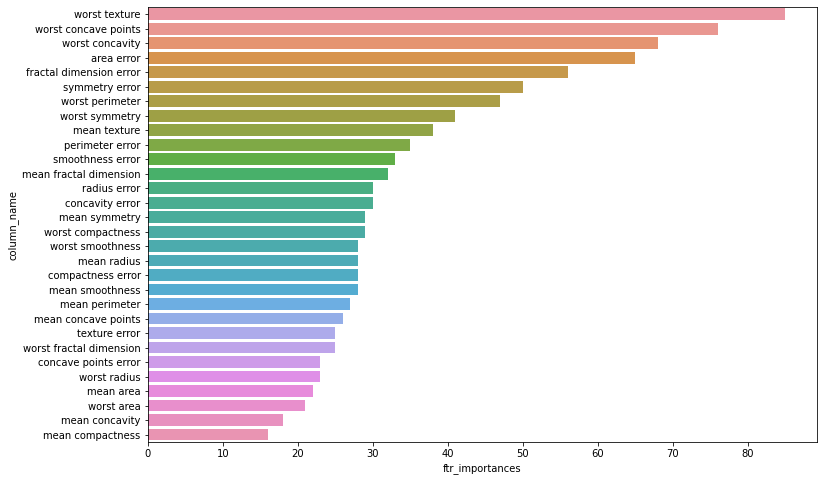

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.figure(figsize=(12, 8))
ftr_df = pd.DataFrame({'ftr_importances':lgbm_model.getFeatureImportances()
                      , 'column_name': cancer_columns})
ftr_df = ftr_df.sort_values(by='ftr_importances', ascending=False)

sns.barplot(data=ftr_df, x='ftr_importances', y='column_name')
plt.show()

In [0]:
lgbm_classifier = LightGBMClassifier(featuresCol="features", labelCol="label", validationIndicatorCol='isVal'
                                    , numLeaves=100, maxDepth=10, numIterations=100
                                    , earlyStoppingRound=10
                                   )
                                    
lgbm_model = lgbm_classifier.fit(tr_val_sdf)
lgbm_predictions = lgbm_model.transform(test_sdf) 

In [0]:
get_clf_eval(lgbm_predictions)

오차 행렬
[[39  1]
 [ 3 71]]
정확도: 0.9649, 정밀도: 0.9861, 재현율: 0.9595, F1: 0.9726, AUC:0.9902
